In [1]:
cd C:\atlastin

C:\atlastin


In [2]:
%matplotlib inline

In [3]:
from collections import OrderedDict
import mfm
from mfm.fluorescence.fps.dynamic import Sticking, Dye, ProteinQuenching, DiffusionSimulationParameter, \
    DiffusionSimulation
from mfm.fluorescence.simulation.dye_diffusion import DyeDecay, DecaySimulationParameter, FRETDecay
from mfm.fitting.models.tcspc.tcspc import FretParameter
from mfm.fitting.optimization import solve_nnls
import numpy as np
import itertools
import os
mfm.verbose = False


def simulate_fret_decays(donors, acceptors, decay_parameter, 
                         simulation_parameter, donor_quenching, acceptor_quenching,
                         fret_parameter, save=True, directory="./", 
                         dye_combinations=None, donor_decays=None):
    donor_keys = donors.keys()
    acceptor_keys = acceptors.keys()
    fret_decays = list()
    
    distances = list()
    eff  = list()
    if dye_combinations is None:
        dye_combinations = itertools.product(donor_keys, acceptor_keys)
        
    for donor_key, acceptor_key in dye_combinations:
        print "Simulating: %sD-%sA" % (donor_key, acceptor_key)
        fn = directory+file_prefix+"_FRET-%sD-%sA_" % (donor_key, acceptor_key)

        donor = donors[donor_key]
        acceptor = acceptors[acceptor_key]

        donor_diffusion_simulation = DiffusionSimulation(donor,
                                                         donor_quenching,
                                                         simulation_parameter)
        donor_diffusion_simulation.update()

        acceptor_diffusion_simulation = DiffusionSimulation(acceptor,
                                                            acceptor_quenching,
                                                            simulation_parameter)
        acceptor_diffusion_simulation.update()
        if save:
            donor_diffusion_simulation.save(filename=fn+"_D_diff.xyz", mode='xyz', skip=10)
            acceptor_diffusion_simulation.save(filename=fn+"_A_diff.xyz", mode='xyz', skip=10)

        fret_sim = FRETDecay(donor_diffusion_simulation, acceptor_diffusion_simulation,
                             fret_parameter, decay_parameter)
        fret_sim.update()
        decay = fret_sim.get_histogram()
        decay = np.vstack(decay)
        if save:
            np.savetxt(fn + "-dRDA.txt" , fret_sim.dRDA.T)
            #np.savetxt(fn +"-decay.txt" , decay.T, fmt="%i", delimiter="\t")
        fret_decays.append(decay)
        distances.append(np.histogram(fret_sim.dRDA, bins=np.linspace(0, 150, 150), density=True))
        donor_decay = donor_decays[donor_key][1]
        print donor_decay
        #print sum(donor_decay)
        eff.append( 1. - sum(decay[1])/sum(donor_decay))
    return fret_decays, distances, eff


def simulate_decays(dyes, decay_parameter, simulation_parameter, quenching_parameter, save_decays=False,
                    directory="./"):
    dye_decays = OrderedDict()
    quantum_yields = list()
    for dye_key in dyes:
        
        dye = dyes[dye_key]
        diffusion_simulation = DiffusionSimulation(dye,
                                                   quenching_parameter,
                                                   simulation_parameter)
        try:
            diffusion_simulation.update()
            #diffusion_simulation.save('%sD_diffusion.xyz' % dye_key, mode='xyz', skip=5)
            av = diffusion_simulation.av
            #av.save('%sD' % dye_key)

            fd0_sim_curve = DyeDecay(decay_parameter, diffusion_simulation)
            fd0_sim_curve.update()
            decay = fd0_sim_curve.get_histogram()
            qy = fd0_sim_curve.quantum_yield
            print "%s\t%s" % (dye_key, qy)
            filename = "Donor-%s.txt" % dye_key
            decay = np.vstack(decay)
            if save_decays:
                np.savetxt(directory+filename, decay.T, fmt="%i", delimiter="\t")
        except ValueError:
            decay = np.ones(10)
        
        dye_decays[dye_key] = decay
        quantum_yields.append(qy)
        
    return quantum_yields, dye_decays

# Simulation parameters

There are two PDBs of hGBP1. Both PDBs are coarse grained models of hGBP1. In the coarse model the sidechains are stripped. Instead of the stripped sidechain are pseudo atom was placed at the center of mass of the side-chain. The program identifies the type of the sidechain by the name of the amino-acid. In one PDB the names of the natural amino-acids were used. In the second PDB the names of the natural quenchers (TYR, TRP, HIS, MET) were replaced by ALA.

Given the PDB-files now a new structure object is generated and the simulation parameters are set.

Input
-----


In [4]:
pdb_file = './crystal/4idn_fixed.pdb' # C2
#pdb_file = './crystal/3q5d_fixed.pdb' # C1
#pdb_file = './crystal/3q5e_fixed.pdb' # C3
file_prefix = 'C2_'
directory = './tmp/'# This directory is used for saving

diffusion_coefficient_donor = 7.5     # A2/ns
diffusion_coefficient_acceptor = 4.0  # A2/ns
r_qd_quench = 3.0 + 5.5 # Distance below the Donor is quenched

rs = [0.2, 0.3, 0.38-0.2, 20] # sum should amplitudes should be 0.38 (0.4) anisotropy spectrum, amplitude, rotational time (interleaved) b1, rho1, b2, rho2, ....
acs = [1.0, 1.5] # This is the lifetime spectrum of the acceptor (interleaved)

# Residue numbers for the attachment of the dyes
donor_labeling_positions = list(set([176, 401, 301, 393, 301, 339, 13, 401, 176, 339, 305, 401, 10, 339, 289, 339, 301, 382, 13, 397]))
acceptor_labeling_positions = list(set([176, 401, 301, 393, 301, 339, 13, 401, 176, 339, 305, 401, 10, 339, 289, 339, 301, 382, 13, 397]))

# These are the FRET-pairs which are going to be simulated (first position D, second A)
dye_combinations = [
    [176, 401], [301, 393], [301, 339], [13, 401], [176, 339], [305, 401], [10, 339], [289, 339], [301, 382], [13, 397],
    [401, 176], [393, 301], [339, 301], [401, 13], [339, 176], [401, 305], [339, 10], [339, 289], [382, 301], [397, 13]
]

dye_combinations = [
    [13, 401],
    [401, 13]
]


In [5]:
structure = mfm.Structure(pdb_file)
tau0 = 4.1
forster_radius = 52.0
kappa2 = 0.667

fret_parameter = FretParameter(tau0=tau0,
                               forster_radius=forster_radius,
                               kappa2=kappa2)

## Donor

In [6]:
donor_chains = [' ']*len(donor_labeling_positions)

donor_quenching = ProteinQuenching(structure,
                                   all_atoms_quench=False,
                                   quench_scale=1.0,
)

donor_sticking = Sticking(structure, donor_quenching,
                          sticky_mode='surface',
                          slow_radius=8.5,
                          slow_fact=0.1)  # Stas-paper Dye-MD (roughly 10%)

donor_dyes = dict(
    [
        (pos,
         Dye(donor_sticking,
             attachment_residue=pos,
             attachment_chain=chain,
             attachment_atom='CB',
             critical_distance=r_qd_quench,  # 3.0 Ang von AV + 6.0 Ang only C-beta quench (so far best 5.0 + 3.0)
             diffusion_coefficient=diffusion_coefficient_donor,  # Stas-paper (Dye-MD 30 A2/ns)
             av_radius=3.0,
             av_width=2.5,
             av_length=21.5,  # 20 + 5 = 3.5 + 21.5
             tau0=4.2)
        )
        for pos, chain in zip(donor_labeling_positions, donor_chains)
    ]
)

## Acceptor

In [7]:
#acceptor_labeling_positions = [18, 254, 577 , 344, 481, 496, 525, 540, 577]

acceptor_chains = [' ']*len(donor_labeling_positions)
acceptor_quenching = ProteinQuenching(structure,
                                      all_atoms_quench=False,
                                      quench_scale=0.8)

acceptor_sticking = Sticking(structure, acceptor_quenching,
                             sticky_mode='surface',
                             slow_radius=8.5,
                             slow_fact=0.1)  # Stas-paper Dye-MD (roughly 10%)
acceptor_quenching = ProteinQuenching(structure,
                                      all_atoms_quench=False,
                                      quench_scale=0.8)
acceptor_dyes = dict(
    [
        (pos,
         Dye(donor_sticking,
             attachment_residue=pos,
             attachment_chain=chain,
             attachment_atom='CB',
             critical_distance=0.0,      # The acceptor dye does not have to be quenched setting this to zero speeds up calulation
             diffusion_coefficient=diffusion_coefficient_acceptor,
             av_radius=3.5,
             av_width=2.5,
             tau0=1.0)
        )
        for pos, chain in zip(acceptor_labeling_positions, acceptor_chains)
    ]
)

# Simulation

## Donor-decay

Now the simulation parameters are set.

In [8]:
simulation_parameter = DiffusionSimulationParameter(t_max=30000,
                                                    t_step=0.016)
decay_parameter = DecaySimulationParameter(decay_mode='photon', #curve or photon
                                           n_photons=20.0e6,
                                           n_curves=250000,
                                           tac_range=(0, 16.666624 + 0.004069),
                                           dt_tac=0.004069)

In [9]:
quantum_yields, donor_decays = simulate_decays(donor_dyes, decay_parameter, simulation_parameter, donor_quenching, directory=directory)
with open(os.path.join(directory, file_prefix+'d0_qy.txt'), 'w') as fp:
    fp.write('Donor position\tQY\n')
    for i, dk in enumerate(donor_decays):
        fp.write("%s\t%.3f\n" % (dk, quantum_yields[i]))

289	0.945020413509
401	0.868100716598
393	0.937943723771
10	0.979737843729
301	0.934255643574
13	0.860857583413
176	0.816218850376
305	0.90661802463
339	0.946292211666
397	0.916740913639
382	0.841078936846


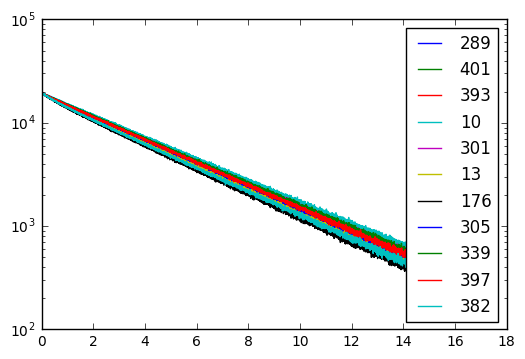

In [10]:
import pylab as p
for k in donor_decays:
    p.semilogy(donor_decays[k][0], donor_decays[k][1], label='%s' % k)
p.legend()
p.show()

In [11]:
def vm_rt_to_vv_vh(t, vm, rs, g_factor=1.0, l1=0.0, l2=0.0):
    """Get the VV, VH decay from an VM decay given an anisotropy spectrum

    :param t: time-axis
    :param vm: magic angle decay
    :param rt: anisotropy spectrum
    :param g_factor: g-factor
    :param l1:
    :param l2:
    :return: vv, vm
    """
    rt = np.zeros_like(vm)
    for i in range(0, len(rs), 2):
        b = rs[i]
        rho = rs[i+1]
        rt += b * np.exp(-t/rho)
    vv = vm * (1 + 2.0 * rt)
    vh = vm * (1. - g_factor * rt)
    vv_j = vv * (1. - l1) + vh * l1
    vh_j = vv * l2 + vh * (1. - l2)
    return vv_j, vh_j

for dk in donor_decays:
    t, vm = donor_decays[dk], donor_decays[dk]
    vv, vh = vm_rt_to_vv_vh(t, vm, rs)
    z = np.ones_like(vm)
    np.savetxt(os.path.join(directory, file_prefix+'D0_%s_vv_vh.txt' % dk), np.vstack([vv,vh, z, z]).T, fmt="%i", delimiter="\t")

## FRET-decay

In [12]:
dye_combinations = [
    [176, 401], [301, 393], [301, 339], [13, 401], [176, 339], [305, 401], [10, 339], [289, 339], [301, 382], [13, 397],
    [401, 176], [393, 301], [339, 301], [401, 13], [339, 176], [401, 305], [339, 10], [339, 289], [382, 301], [397, 13]
]
fret_decays, distance_distributions, transfer_eff = simulate_fret_decays(donor_dyes, acceptor_dyes, 
                                                           decay_parameter, 
                                                           simulation_parameter, 
                                                           donor_quenching, acceptor_quenching, fret_parameter, 
                                                           dye_combinations=dye_combinations,
                                                            donor_decays=donor_decays,
                                                                        directory=directory)

Simulating: 176D-401A
[ 19264.  19479.  19265. ...,    177.    210.    205.]
Simulating: 301D-393A
[ 19439.  19358.  19469. ...,    252.    286.    284.]
Simulating: 301D-339A
[ 19439.  19358.  19469. ...,    252.    286.    284.]
Simulating: 13D-401A
[ 19527.  19107.  19538. ...,    222.    217.    220.]
Simulating: 176D-339A
[ 19264.  19479.  19265. ...,    177.    210.    205.]
Simulating: 305D-401A
[ 19611.  19191.  19138. ...,    263.    258.    268.]
Simulating: 10D-339A
[ 19245.  19438.  19111. ...,    320.    339.    358.]
Simulating: 289D-339A
[ 19500.  19631.  19300. ...,    311.    344.    309.]
Simulating: 301D-382A
[ 19439.  19358.  19469. ...,    252.    286.    284.]
Simulating: 13D-397A
[ 19527.  19107.  19538. ...,    222.    217.    220.]
Simulating: 401D-176A
[ 19358.  19169.  19345. ...,    240.    245.    218.]
Simulating: 393D-301A
[ 19410.  19205.  19547. ...,    287.    305.    306.]
Simulating: 339D-301A
[ 19429.  19281.  19379. ...,    317.    295.    324.]
Si

In [13]:


def scale_acceptor(donor, acceptor, transfer_efficency):
    s_d = sum(donor)
    s_a = sum(acceptor)
    scaling_factor = 1. / ((s_a / transfer_efficency - s_a) / s_d)
    scaled_acceptor = acceptor * scaling_factor
    return donor, scaled_acceptor

def da_a0_to_ad(t, da, ac_s):
    """Convolves the donor decay in presence of FRET directly with the acceptor only decay to give the
     FRET-sensitized decay ad
    """
    a0 = np.zeros_like(da)
    for i in range(len(ac_s) / 2):
        a = ac_s[i]
        tau = ac_s[i + 1]
        a0 += a * np.exp(-t / tau)
    ad = np.convolve(da, a0, mode='full')[:len(da)]
    ds = da.sum()
    return ad

for i, dk in enumerate(dye_combinations):
    d, a = dk
    t, fd0 = donor_decays[d]
    t, fda = fret_decays[i]
    fad = da_a0_to_ad(t, fda, acs)
    tr = transfer_eff[i]
    fda, fad = scale_acceptor(fda, fad, tr)
    fda_vv, fda_vh = vm_rt_to_vv_vh(t, fda, rs)
    fad_vv, fad_vh = vm_rt_to_vv_vh(t, fad, rs)
    np.savetxt(os.path.join(directory, file_prefix+'FRET_%sD-%sA_vv_vh.txt' % (dk[0], dk[1])), 
               np.vstack([fda_vv,fda_vh, fad_vv, fad_vh]).T,
              fmt="%i", delimiter="\t")


In [14]:
with open(os.path.join(directory, file_prefix+'tr.txt'), 'w') as fp:
    fp.write('Dye-pair\ttransfer\n')
    for i, dk in enumerate(dye_combinations):
        fp.write('%sD-%sA\t%.3f\n' % (dk[0], dk[1], transfer_eff[i]))


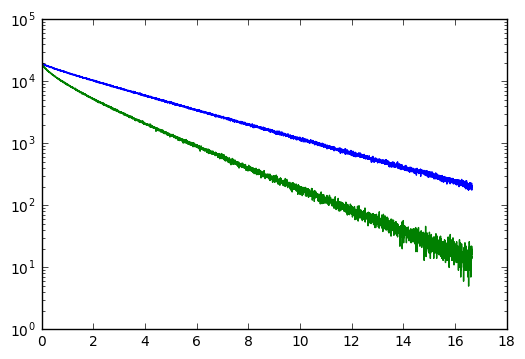

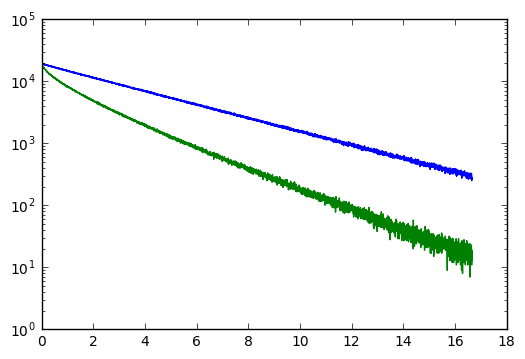

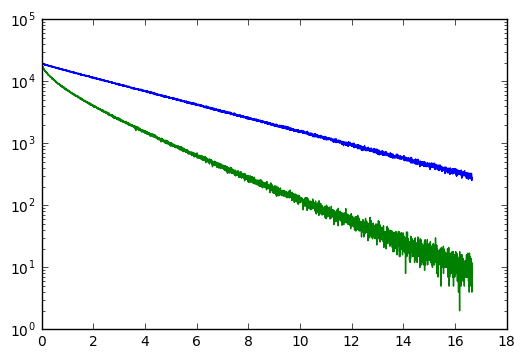

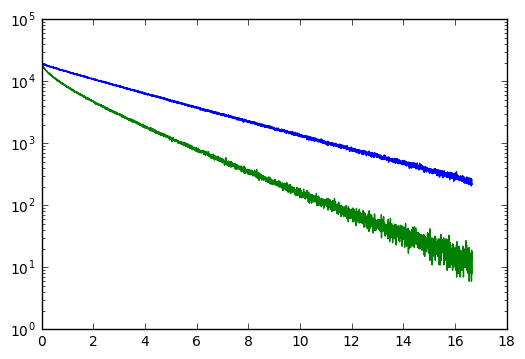

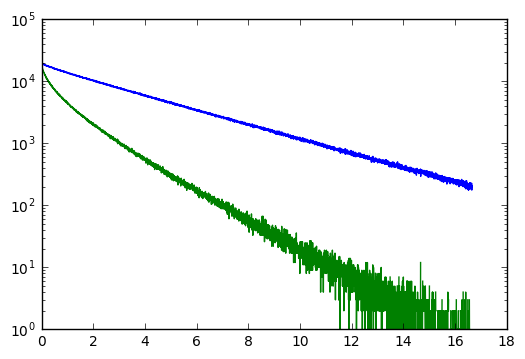

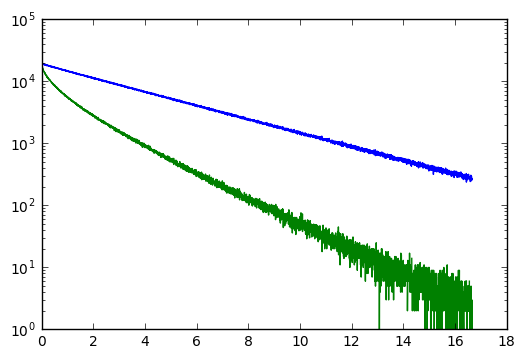

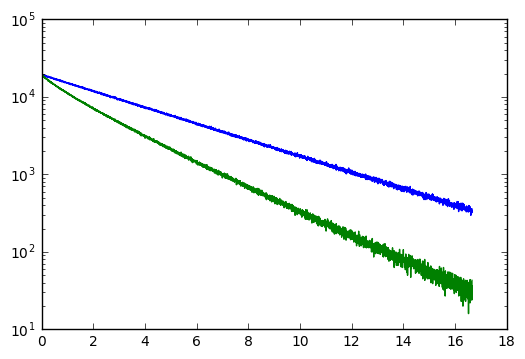

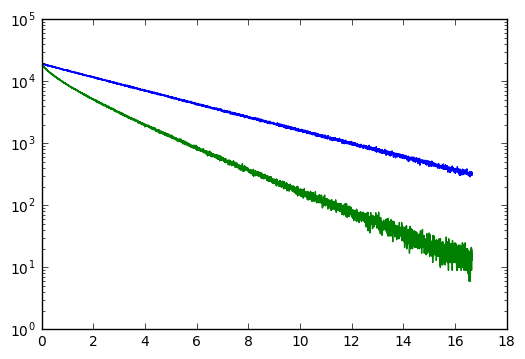

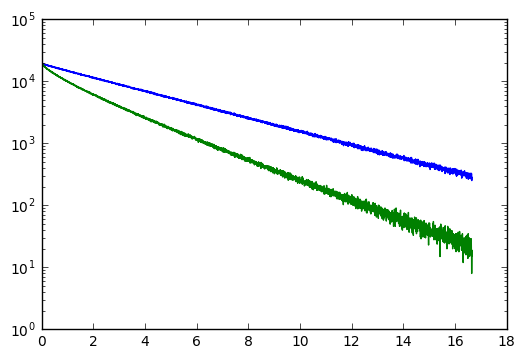

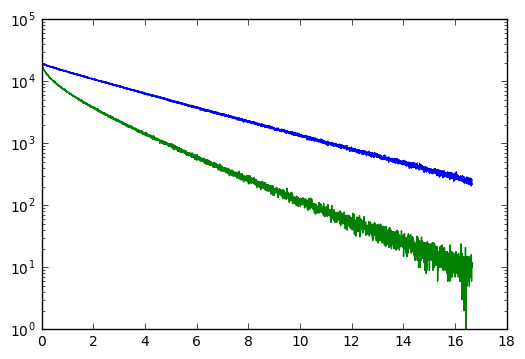

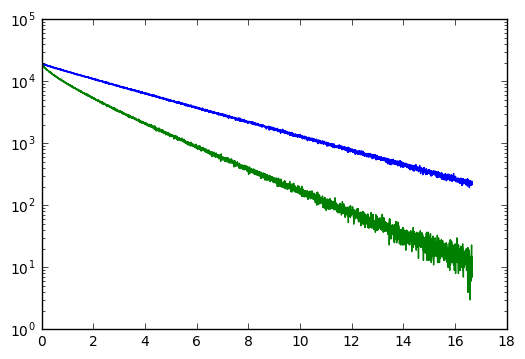

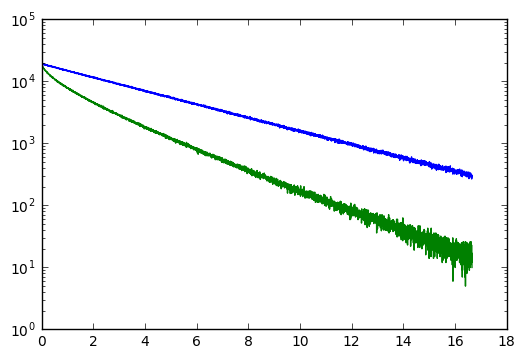

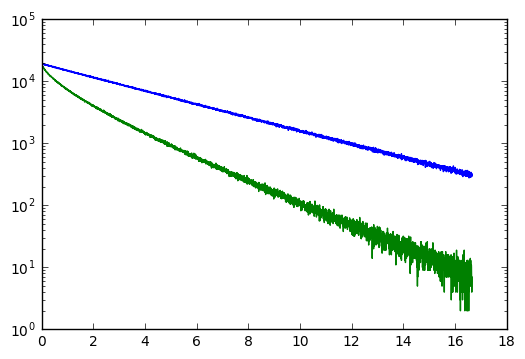

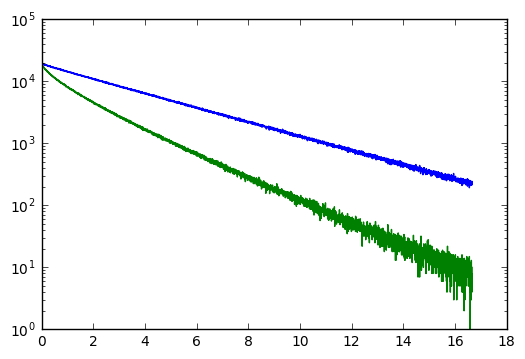

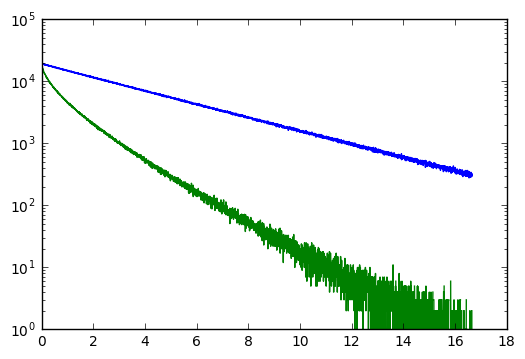

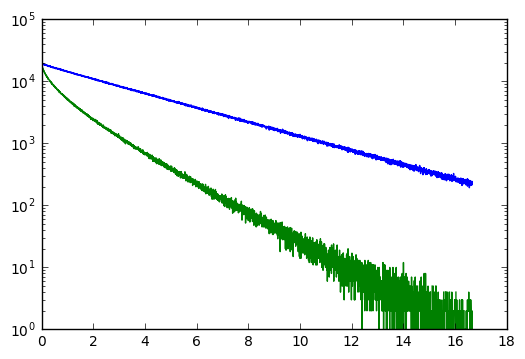

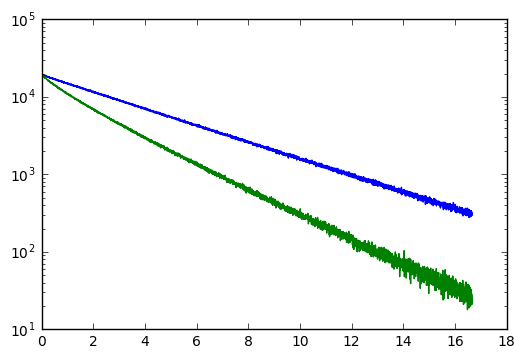

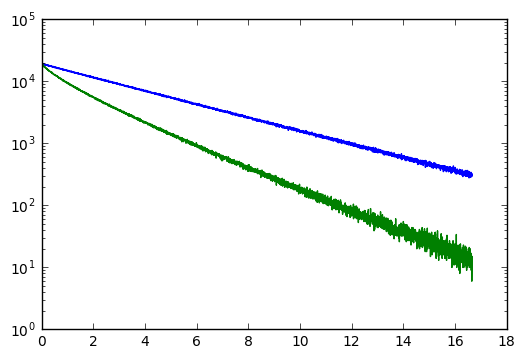

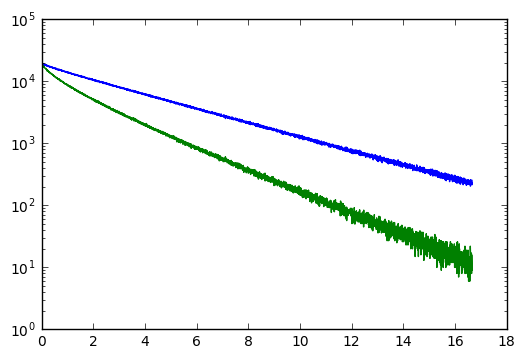

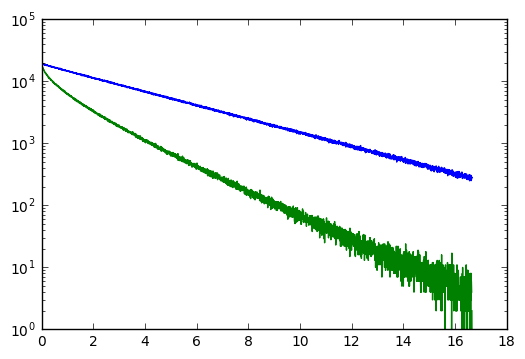

In [15]:
for i, (d, a) in enumerate(dye_combinations):
    t, fd0 = donor_decays[d]
    p.semilogy(t, fd0)
    t, fda = fret_decays[i]
    p.semilogy(t, fda)
    p.show()